# 親子関係
- 親変数:他の変数に影響を与える変数
- 子変数:他の変数から影響を受ける変数

In [1]:
# import
import numpy as np
import scipy
import pymc as pm

from IPython.core.pylabtools import figsize
from os import makedirs
from urllib.request import urlretrieve
from matplotlib import pyplot as plt
%matplotlib inline

- lambda_がdata_generatorの親
- data_generatorはdata_plus_oneの親

In [10]:
lambda_ = pm.Exponential("poisson_param", 1)

# これは次の変数を生成する関数呼び出しに使われている
data_generator = pm.Poisson("data_generator", lambda_)
data_plus_one = data_generator + 1

print("Children of `parameter`: ")
print(lambda_.children)
print("\nParents of `data_generator`: ")
print(data_generator.parents)
print("\nChildren of `data_generator`: ")
print(data_generator.children)

Children of `parameter`: 
{<pymc.distributions.new_dist_class.<locals>.new_class 'data_generator' at 0x10c2f3a58>}

Parents of `data_generator`: 
{'mu': <pymc.distributions.new_dist_class.<locals>.new_class 'poisson_param' at 0x102e43e80>}

Children of `data_generator`: 
{<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x1035b9da0>}


# PyMC変数
- 全てのPyMC変数はvalueプロパティ(現在の内部状態)を持っている

In [11]:
print("lambda_.value =", lambda_.value)
print("data_generator.value =", data_generator.value)
print("data_plus_one.value =", data_plus_one.value)

lambda_.value = 0.9792564385053757
data_generator.value = 2
data_plus_one.value = 3


PyMC変数にはstochasticとdeterministicの2種類がある

- stochastic変数:親変数の値を知っていたとしても、その変数の値は依然としてランダムである変数
- deterministic変数:親変数の値が分かっていれば、その値が決まる変数

## stochastic変数の初期化

In [14]:
discrete_uni_var = pm.DiscreteUniform("discrete_uni_var", 0, 4)
# 変数の情報を確認できる
discrete_uni_var??
help(discrete_uni_var)

Help on DiscreteUniform in module pymc.distributions object:

discrete_uni_var = class DiscreteUniform(pymc.PyMCObjects.Stochastic)
 |  D = DiscreteUniform(name, lower, upper, value=None, observed=False, size=1, trace=True, rseed=True, doc=None, verbose=-1, debug=False)
 |  
 |  Stochastic variable with DiscreteUniform distribution.
 |  Parents are: lower, upper.
 |  
 |  Docstring of log-probability function:
 |  
 |      Discrete uniform log-likelihood.
 |  
 |      .. math::
 |          f(x \mid lower, upper) = \frac{1}{upper-lower}
 |  
 |      :Parameters:
 |        - `x` : [int] :math:`lower \leq x \leq upper`
 |        - `lower` : Lower limit.
 |        - `upper` : Upper limit (upper > lower).
 |  
 |  Method resolution order:
 |      DiscreteUniform
 |      pymc.PyMCObjects.Stochastic
 |      pymc.Node.StochasticBase
 |      pymc.six.NewBase
 |      pymc.Node.Variable
 |      pymc.Node.Node
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **

In [16]:
N = 2
beta_1 = pm.Uniform("beta_1", 0, 1)
beta_2 = pm.Uniform("beta_2", 0, 1)
# よりも
betas = pm.Uniform("betas", 0, 1, size=N)

## random()を呼び出す

In [17]:
lambda_1 = pm.Exponential("lambda_1", 1)  # prior on first behaviour
lambda_2 = pm.Exponential("lambda_2", 1)  # prior on second behaviour
tau = pm.DiscreteUniform("tau", lower=0, upper=10)  # prior on behaviour change

print("Initialized values...")
print("lambda_1.value = %.3f" % lambda_1.value)
print("lambda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value, "\n")

lambda_1.random()
lambda_2.random()
tau.random()

print("After calling random() on the variables...")
print("lambda_1.value = %.3f" % lambda_1.value)
print("lambda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value)

Initialized values...
lambda_1.value = 2.664
lambda_2.value = 1.331
tau.value = 4.000 

After calling random() on the variables...
lambda_1.value = 0.052
lambda_2.value = 1.537
tau.value = 2.000


## deterministic変数
- PyMCで扱う変数はほぼstocasticなので、区別するためにpymc.deterministicラッパーを使う

```python
@pm.deterministic
def some_deterministic_var(v1=v1,):
    pass
```
- 以降ではオブジェクトsome_deterministic_varを変数として扱う

In [18]:
type(lambda_1 + lambda_2)

pymc.PyMCObjects.Deterministic

$$ 
\begin{eqnarray}
\lambda = 
\left\{
\begin{array}{l}
\lambda_1 (t<\tau のとき)\\
\lambda_2 (t\geq \tau のとき)
\end{array}
\right.
\end{eqnarray}
$$

- もし$\tau, \lambda_1, \lambda_2$がわかれば$\lambda$の値がわかる

In [19]:
import numpy as np
n_data_points = 5  # in CH1 we had ~70 data points

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after tau is lambda2
    return out

- deterministicデコレータの中へと渡されたstochastic変数は、stochastic変数とは異なりスカラーのように振る舞う
- **deterministic関数はキーワード変数で渡さないといけない**

```python
@pm.deterministic
def some_deterministic(stoch=discrete_uni_var):
    # return stoch.value**2 ←エラー
    return stoch**2  # ←これでよい
```

## モデルに観測を組み込む

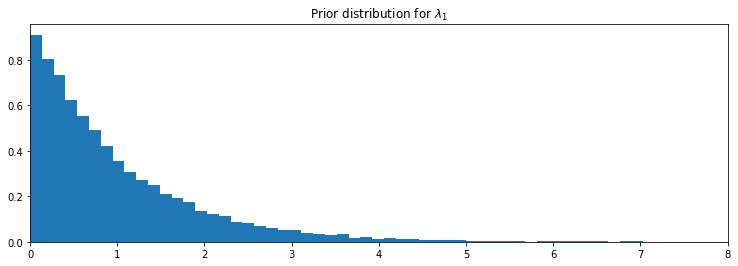

In [21]:
figsize(12.5, 4)

samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype="stepfilled")
plt.title("Prior distribution for $\lambda_1$")
plt.xlim(0, 8);

- データをモデルに組み込む
- stochastic変数にはobservedキーワード変数がある
- observed:現在の値を固定する(valueを変更不可)

In [25]:
data = np.array([10, 5])
fixed_variable = pm.Poisson("fxd", 1, value=data, observed=True)
print("value: ", fixed_variable.value)
print("calling .random()")
fixed_variable.random()
print("value: ", fixed_variable.value)

value:  [10  5]
calling .random()
value:  [10  5]


In [26]:
# We're using some fake data here
data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson("obs", lambda_, value=data, observed=True)
print(obs.value)

[10 25 15 20 35]


In [27]:
# 最後にラッピング
model = pm.Model([obs, lambda_, lambda_1, lambda_2, tau])